URN: 6831863

# NLP CW

## Installing libraries

In [1]:
%pip install datasets
from datasets import load_dataset, load_metric
%pip install nltk
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
dataset = load_dataset("surrey-nlp/PLOD-CW")
nltk.download('punkt')
%pip install torch==1.11.0+cu113 torchdata==0.3.0 torchtext==0.6.0 -f https://download.pytorch.org/whl/cu113/torch_stable.html
%pip install spacy tqdm
!python -m spacy download en_core_web_sm
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.optim as optim
from torchtext.data import Field, Dataset, Example, BucketIterator
from collections import OrderedDict
!pip install spacy
import numpy as np
import torch.optim as optim
from collections import Counter
import spacy
from torch.nn import Module
import math
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
!pip install gensim
import gensim.downloader as api
from gensim.models import KeyedVectors
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,  confusion_matrix, ConfusionMatrixDisplay

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1072 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/126 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/153 [00:00<?, ? examples/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 GB 665.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1+cu121
    Uninstalling torch-2.2.1+cu121:
      Successfully uninstalled torch-2.2.1+cu121
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.17.1
    Uninstalling torchtext-0.17.1:
      Successfully uninstalled torchtext-0.17.1
  Attempting uninstall: torchdata
    Found existing installation: torchdata 0.7.1
    Uninstalling torchdata-0.7.1:
      Successfully uninstalled torchdata-0.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.

## 1. Loading and Visualisation of data

### Loading the data

In [2]:
train_dataset = dataset["train"]    #Loading the training set
val_dataset = dataset["validation"] #Loading the Validation set
test_dataset = dataset["test"]      #Loading the test set
unique_labels = set(tag for sublist in train_dataset['ner_tags'] for tag in sublist)
print(unique_labels) #Displaying the unique labels

{'B-AC', 'I-LF', 'B-O', 'B-LF'}


### Visualisation

In [3]:
#Analysing the distribution of labels in the dataset:
def analyze_label_distribution(dataset):
    # Flattening the list of lists of tags into a single list of tags
    all_tags = [tag for sublist in dataset['ner_tags'] for tag in sublist]
    # Counting each unique tag's occurrences
    tag_counts = Counter(all_tags)
    return tag_counts

# Analyzing label distribution for each dataset split
train_label_distribution = analyze_label_distribution(train_dataset)
val_label_distribution = analyze_label_distribution(val_dataset)
test_label_distribution = analyze_label_distribution(test_dataset)

#Printing them out
print("Training Label Distribution:", train_label_distribution)
print("Validation Label Distribution:", val_label_distribution)
print("Test Label Distribution:", test_label_distribution)

Training Label Distribution: Counter({'B-O': 32971, 'I-LF': 3231, 'B-AC': 2336, 'B-LF': 1462})
Validation Label Distribution: Counter({'B-O': 4261, 'I-LF': 327, 'B-AC': 263, 'B-LF': 149})
Test Label Distribution: Counter({'B-O': 4292, 'I-LF': 288, 'B-AC': 270, 'B-LF': 150})


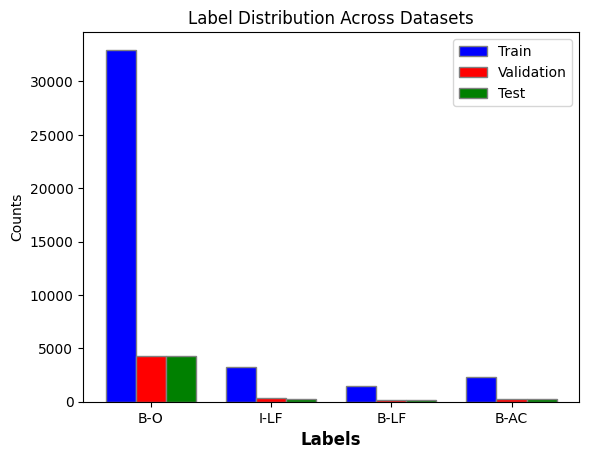

In [4]:
#Function to plot the label distributions across all datasets:
def plot_label_distributions(train_dist, val_dist, test_dist):
    # Collecting all unique labels from the distributions
    all_labels = set(train_dist.keys()).union(val_dist.keys()).union(test_dist.keys())
    # Preparing data for plotting
    train_counts = [train_dist.get(label, 0) for label in all_labels]
    val_counts = [val_dist.get(label, 0) for label in all_labels]
    test_counts = [test_dist.get(label, 0) for label in all_labels]

    # Creating the bar chart
    bar_width = 0.25
    r1 = range(len(all_labels))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    plt.bar(r1, train_counts, color='b', width=bar_width, edgecolor='grey', label='Train')
    plt.bar(r2, val_counts, color='r', width=bar_width, edgecolor='grey', label='Validation')
    plt.bar(r3, test_counts, color='g', width=bar_width, edgecolor='grey', label='Test')

    plt.xlabel('Labels', fontweight='bold', fontsize=12)
    plt.xticks([r + bar_width for r in range(len(all_labels))], list(all_labels))
    plt.ylabel('Counts')
    plt.title('Label Distribution Across Datasets')
    plt.legend()

    plt.show()

# Using the function the distributions
plot_label_distributions(train_label_distribution, val_label_distribution, test_label_distribution)

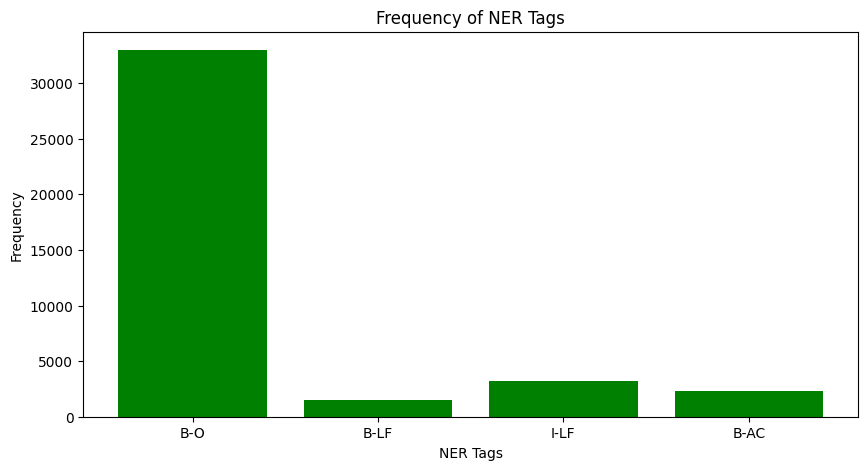

In [5]:
#Clearer label/Ner-Tag distribution:

all_ner_tags = [tag for example in train_dataset['ner_tags'] for tag in example]

# Calculating the frequency of each tag
tag_freq = Counter(all_ner_tags)

# Plotting the tag frequencies
tags, freqs = zip(*tag_freq.items())

plt.figure(figsize=(10, 5))
plt.bar(tags, freqs, color='green')
plt.xlabel('NER Tags')
plt.ylabel('Frequency')
plt.title('Frequency of NER Tags')
plt.show()

52
46
85


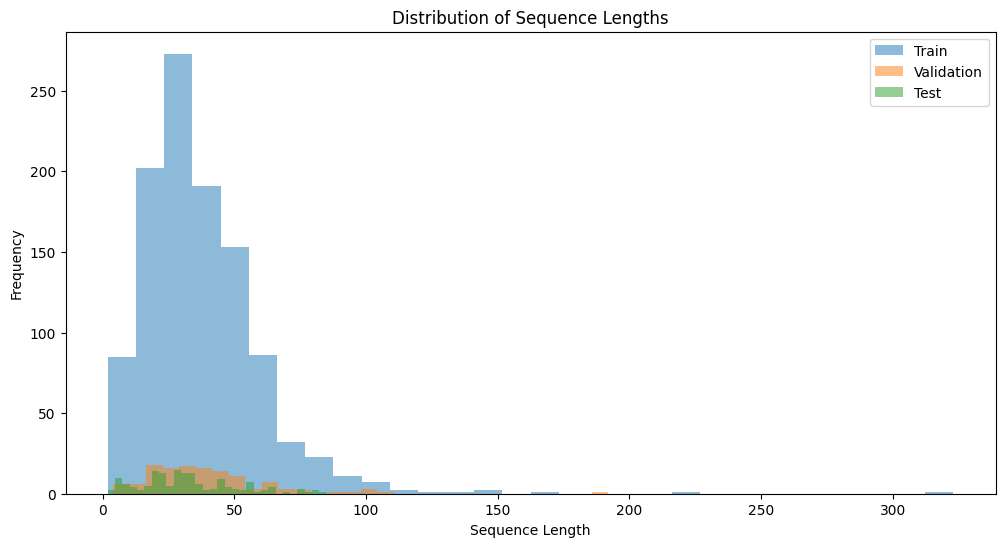

In [6]:
#Function to anlayse the sequence length:
def analyze_sequence_lengths(dataset):
    # Getting the length of each sequence in the dataset
    sequence_lengths = [len(tokens) for tokens in dataset['tokens']]
    return sequence_lengths

# Analyzing sequence lengths for each dataset split
train_lengths = analyze_sequence_lengths(train_dataset)
val_lengths = analyze_sequence_lengths(val_dataset)
test_lengths = analyze_sequence_lengths(test_dataset)
#Printing the length of first sequence in each dataset split
print(train_lengths[1])
print(val_lengths[1])
print(test_lengths[1])

# Plotting the distribution of sequence lengths
plt.figure(figsize=(12, 6))
plt.hist(train_lengths, bins=30, alpha=0.5, label='Train')
plt.hist(val_lengths, bins=30, alpha=0.5, label='Validation')
plt.hist(test_lengths, bins=30, alpha=0.5, label='Test')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

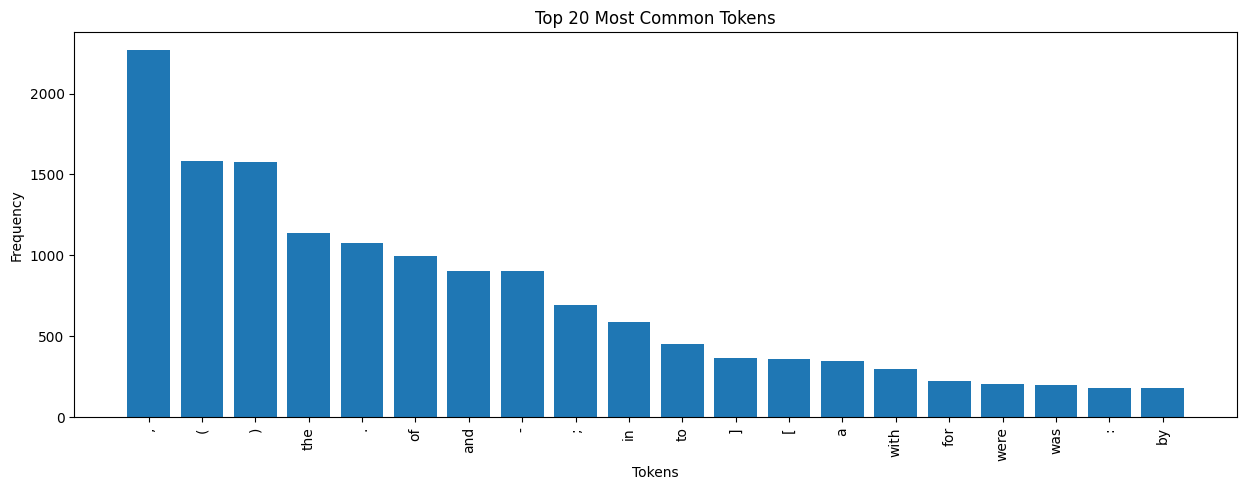

In [7]:
#token frequence in training data:
from collections import Counter
import matplotlib.pyplot as plt

# Flattening all tokens from the training set into one list
all_tokens = [token for example in train_dataset['tokens'] for token in example]


# Calculating the frequency of each token
token_freq = Counter(all_tokens)

# Sorting tokens by frequency and taking the top 20
most_common_tokens = token_freq.most_common(20)

# Unzipping the tokens and their frequencies for plotting
tokens, freqs = zip(*most_common_tokens)

# Plotting the token frequencies
plt.figure(figsize=(15, 5))
plt.bar(tokens, freqs)
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate token names for better readability
plt.title('Top 20 Most Common Tokens')
plt.show()

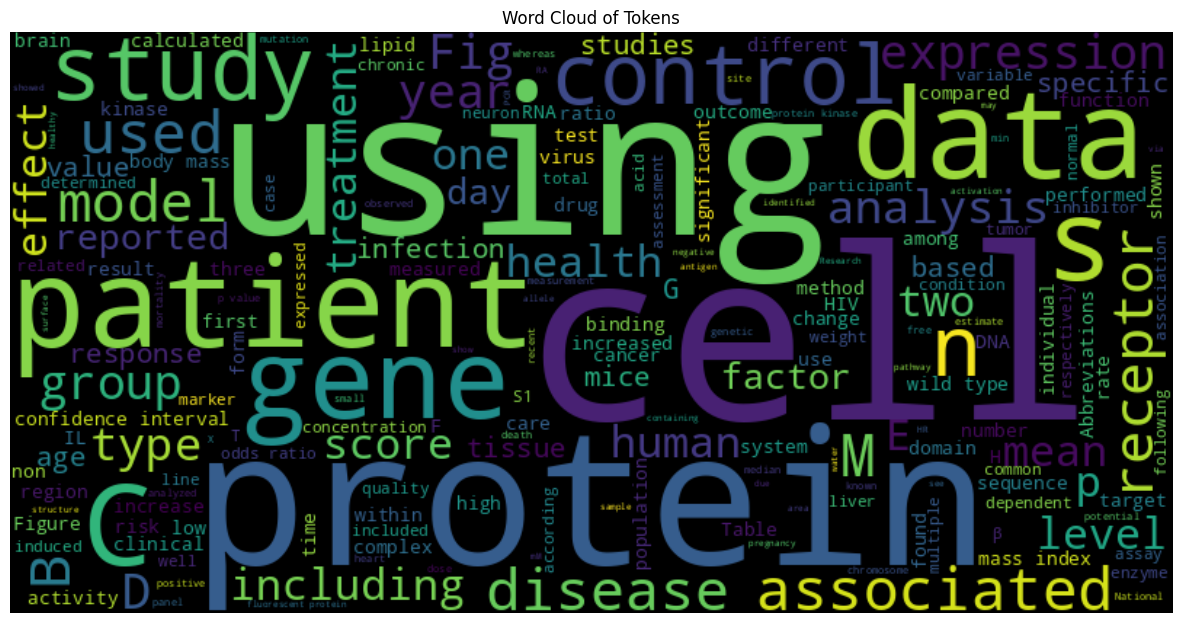

In [8]:
#Creating the Word cloud
from wordcloud import WordCloud

# Creating a single string with all tokens separated by spaces
all_tokens_string = ' '.join(all_tokens)

# Generating a word cloud
wordcloud = WordCloud(width=800, height=400).generate(all_tokens_string)

# Displaying the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.title('Word Cloud of Tokens')
plt.show()

## Preprocessing

### Building example objects
Creation of Example objects which can be easily iterated over and used for training and evaluation

In [3]:
# Defining the Field for the text, telling it that our data is sequential, and we want to include the length of each sequence
text_field = Field(sequential=True, tokenize=lambda x: x, include_lengths=True)

# Defining the Field for the labels in the same way, setting is_target to True to indicate this is what we're predicting
label_field = Field(sequential=True, tokenize=lambda x: x, is_target=True)

# Dictionary mapping the field name to the corresponding Field object
fields = {
    'sentences': ('text', text_field),
    'ids': ('label', label_field)
}

# Function to read the data from a DataFrame into a torchtext Dataset
def read_data(df):
    # List to store examples, where each example is a data point
    examples = []

    # Defining the structure of the examples: they are made up of 'sentence_tokens' and 'sentence_labels'
    fields = {
        'sentence_tokens': ('text', text_field),
        'sentence_labels': ('labels', label_field)
    }

    # Looping over the DataFrame
    for i in range(len(df)):
        # Extracting tokens and labels for each row in the DataFrame
        tokens = df['tokens'][i]
        labels = df['ner_tags'][i]

        # Creating an Example from the tokens and labels using the specified fields
        e = Example.fromdict({
            "sentence_tokens": tokens,
            "sentence_labels": labels
        }, fields)

        # Appending the example to the list of examples
        examples.append(e)

    # Returning a Dataset object created from the list of examples and the specified fields
    return Dataset(examples, fields=[('text', text_field), ('labels', label_field)])

# Creating datasets for training, validation, and testing by reading the data from corresponding splits
train_data = read_data(train_dataset)  # Reading and processing the training data
val_data = read_data(val_dataset)      # Reading and processing the validation data
test_data = read_data(test_dataset)    # Reading and processing the test data

### Building a Vocabulary and Data Iterator

In [4]:
# Defining the maximum size of the vocabulary to include the most frequent tokens
VOCAB_SIZE = 20000

# Building the vocabulary for the text field using only the top VOCAB_SIZE tokens from the training set
text_field.build_vocab(train_data, max_size=VOCAB_SIZE)

# Building the vocabulary for the label field using all labels in the training set (no max_size as we need all labels)
label_field.build_vocab(train_data)

# Setting the batch size for batch iterators
BATCH_SIZE = 16

# Creating a BucketIterator for the training data to iterate over it in batches
# The iterator shuffles the data and groups sequences of similar lengths into the same batch
# This helps in minimizing the amount of padding needed and thus is computationally efficient
train_iter = BucketIterator(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True,
                            sort_key=lambda x: len(x.text), sort_within_batch=True)

# Creating a BucketIterator for the validation data similar to train_iter
# Data is not shuffled here as it's not needed for evaluation
val_iter = BucketIterator(dataset=val_data, batch_size=BATCH_SIZE,
                          sort_key=lambda x: len(x.text), sort_within_batch=True)

# Create a BucketIterator for the test data similar to val_iter
test_iter = BucketIterator(dataset=test_data, batch_size=BATCH_SIZE,
                           sort_key=lambda x: len(x.text), sort_within_batch=True)

##2. Experimentation

### 2.1. Text Encoding of data
Open to pick different text encoding methods

In [5]:
# Loading pre-trained 300 dimensional Word2Vec embeddings
word2vec_model = api.load("word2vec-google-news-300")

# Loading pre-trained 300 dimensional GloVe embeddings
glove_model = api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded
[==================================================] 100.0% 376.1/376.1MB downloaded


In [6]:
# Setting the size for the word embeddings
EMBEDDING_DIM = 300 # This is a typical dimension size for word embeddings like Word2Vec and GloVe

# Defining a function to create an embedding matrix
def create_embedding_matrix(model, field_vocab, embedding_dim):
    # Determining the size of the vocabulary
    matrix_len = len(field_vocab)
    # Initializing a matrix of zeros with dimensions of vocabulary size x embedding dimensions
    weights_matrix = torch.zeros((matrix_len, embedding_dim))

    # Looping through the vocabulary
    for i, word in enumerate(field_vocab.itos):  # itos: index-to-string list of the Field's vocabulary
        try:
            # If the word is in the model, use the corresponding embedding vector
            weights_matrix[i] = torch.from_numpy(model[word]).clone()
        except KeyError:
            # If the word is not in the model, initialize a random vector
            weights_matrix[i] = torch.randn((embedding_dim,))
    # Return the completed matrix containing the embeddings for the vocabulary
    return weights_matrix

# Creating embedding matrix for Word2Vec embeddings
word2vec_weights = create_embedding_matrix(word2vec_model, text_field.vocab, EMBEDDING_DIM)

# Creating embedding matrix for GloVe embeddings
glove_weights = create_embedding_matrix(glove_model, text_field.vocab, EMBEDDING_DIM)

<ipython-input-6-282f3ca7ad00>:15: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  weights_matrix[i] = torch.from_numpy(model[word]).clone()


####Run this cell if you want to select Word2Vec

In [10]:
pretrained_embeddings = word2vec_weights

####Run this cell if you want to select GloVe

In [ ]:
pretrained_embeddings = glove_weights

### 2.2. Building and initialising Different NLP Algorithms
Open to pick different architectures

In [13]:
# Setting the size of the hidden layers for the LSTM model
HIDDEN_DIM = 256  # This is the dimensionality of the LSTM's hidden states

# Determining the number of unique classes or labels in the label field's vocabulary
# This is important as it defines the output size of the model's final layer
NUM_CLASSES = len(label_field.vocab)

# Outputting the number of classes to the console, which is useful for verification
print(f"Number of classes: {NUM_CLASSES} : {label_field.vocab.itos}")

# Calculating the size of the vocabulary based on the text field
vocab_size = len(text_field.vocab)

Number of classes: 6 : ['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF']


#### 2.2.1 BiLSTM-Tagger
If you want to experiment on this model, run the two cells in this subsection

In [14]:
# Defining the BiLSTMTagger class which inherits from nn.Module
class BiLSTMTagger(nn.Module):

    # Initializing the class with given parameters
    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, embeddings=None):
        super(BiLSTMTagger, self).__init__()  # Initializing the parent class

        # 1. Embedding Layer: If pre-trained embeddings are not provided, initializing an embedding layer from scratch
        if embeddings is None:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        else:
            # If pre-trained embeddings are provided, initializing the embedding layer with these embeddings
            self.embeddings = nn.Embedding.from_pretrained(embeddings, freeze=False) #freeze=False ensures that the embeddings can be updated

        # 2. LSTM Layer: Defining a bidirectional LSTM layer with specified hidden dimensions
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=1)

        # 3. Dropout Layer: Defining a dropout layer with a 50% drop rate to prevent overfitting
        self.dropout_layer = nn.Dropout(p=0.5) #it is optional, can remove if needed.

        # 4. Dense Layer (Fully Connected Layer): Mapping the output of the LSTM to the desired output size (number of classes)
        # Since the LSTM is bidirectional, we multiply the hidden_dim by 2
        self.hidden2tag = nn.Linear(2*hidden_dim, output_size)

    # Defining the forward pass through the network
    def forward(self, batch_text, batch_lengths):
        # Embedding the batch of text using the embedding layer
        embeddings = self.embeddings(batch_text)

        # Packing the sequence of embeddings along with their lengths for efficient processing by the LSTM
        packed_seqs = pack_padded_sequence(embeddings, batch_lengths)

        # Passing the packed sequences through the LSTM
        lstm_output, _ = self.lstm(packed_seqs)

        # Unpacking the sequences after the LSTM
        lstm_output, _ = pad_packed_sequence(lstm_output)

        # Applying dropout to the output of the LSTM
        lstm_output = self.dropout_layer(lstm_output)

        # Passing the LSTM output through the dense layer to get logits for each class
        logits = self.hidden2tag(lstm_output)

        # Returning the logits
        return logits

In [15]:
# Creating an instance of the BiLSTMTagger model with the specified parameters
model = BiLSTMTagger(
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    vocab_size=vocab_size,
    output_size=NUM_CLASSES,
    embeddings=pretrained_embeddings
)

# Determine the device to run the model on (GPU if available, otherwise CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
model = model.to(DEVICE)

# Function to count the total number of trainable parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
# This gives an idea of the model's complexity and memory demands
print(f"Model has been initialized with {count_parameters(model):,} trainable parameters.")


Using device: cpu
Model has been initialized with 3,886,362 trainable parameters.


#### 2.2.2 FFNN-Tagger
If you want to use this model, run the two cells of code in this subsection

In [16]:
class FFNNTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, embeddings=None): #Initialising the model
        super(FFNNTagger, self).__init__()

        # 1. Embedding Layer
        if embeddings is None:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embeddings = nn.Embedding.from_pretrained(embeddings, freeze=False)

        # 2. Feedforward layers
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_size)

        # 3. Optional dropout layer
        self.dropout_layer = nn.Dropout(p=0.5)

    def forward(self, batch_text, batch_lengths=None):
        # batch_lengths isn't needed for FFNN, but it does not affect it negatively
        embeddings = self.embeddings(batch_text)
        embeddings = embeddings.view(-1, embeddings.shape[2])  # Flatten the embeddings

        x = self.dropout_layer(F.relu(self.fc1(embeddings)))
        logits = self.fc2(x)
        return logits.view(batch_text.size(0), batch_text.size(1), -1)  # Reshape to have the same output format as LSTM, to improve efficiency of code.

In [17]:
# Creating an instance of the model
model = FFNNTagger(
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    vocab_size=vocab_size,
    output_size=NUM_CLASSES,
    embeddings=pretrained_embeddings
)

# Transfering the model to GPU if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Function to count number of trainable parameters in the model.
print(f"Using device: {DEVICE}")
model = model.to(DEVICE)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model has been initialized with {count_parameters(model):,} trainable parameters.")

Using device: cpu
Model has been initialized with 2,819,098 trainable parameters.


###2.3. Optimizers and Loss functions
Open the cell to pick Optimizer and Loss function



In [31]:
# Defining a class for Label Smoothing Loss, which is a subclass of nn.Module
class LabelSmoothingLoss(nn.Module):
    # Initializing of the class with required parameters
    def __init__(self, classes, smoothing=0.1, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        # Confidence is calculated as 1 minus the smoothing factor
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        # Dimension along which softmax will be computed, typically -1 indicating the last dimension
        self.dim = dim

    # Defining the forward pass which computes the label smoothing loss
    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # Creating a distribution for the true labels with the same shape as predictions
            true_dist = torch.zeros_like(pred)
            # Filling the true distribution uniformly with the smoothing value divided among non-true classes
            true_dist.fill_(self.smoothing / (self.cls - 1))
            # For each label in the target, replacing the corresponding entry with the confidence value
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        # Computing the loss as the mean of the sum of negative log likelihood times the true distribution
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

#### Optimizers

##### To select Adam, run this cell

In [ ]:
optimizer = optim.Adam(model.parameters())

##### To select AdamW, run this cell

In [17]:
optimizer = optim.AdamW(model.parameters())

##### To select AdaGrad, run this cell

In [ ]:
optimizer = optim.Adagrad(model.parameters())

#### Loss Functions

##### To select Cross Entropy Loss, run this cell

In [19]:
criterion = nn.CrossEntropyLoss()

##### To select Label Smoothing loss, run this cell

In [32]:
criterion = LabelSmoothingLoss(classes=NUM_CLASSES, smoothing=0.1)

### 2.4. Hyperparameter Optimization
Open the cell to pick hyperparameters


#### Learning rate

##### Run this cell if you want lr=0.001

In [20]:
lr=0.001

##### Run this cell if you want lr=0.01

In [ ]:
lr=0.01

##### Run this cell if you want lr=0.0001

In [33]:
lr=0.0001

#### Number of Epochs

##### Run this cell if you want 30 epochs

In [ ]:
MAX_EPOCHS = 30

##### Run this cell if you want 40 epochs

In [ ]:
MAX_EPOCHS = 40

##### Run this cell if you want 10 epochs

In [21]:
MAX_EPOCHS = 10

##### Run this cell if you want 7 epochs

In [ ]:
MAX_EPOCHS = 7

## Training

In [22]:
#Must run this cell to initialise the chosen optimizer with the chosen learning rate:
for param_group in optimizer.param_groups:
    param_group['lr'] = lr

In [20]:
#Uncomment the below line only if google drive is connected and a folder exists at the path specified below. Otherwise just comment it out
#base_dir = '/content/drive/MyDrive/NLP/Models' #setting the path to store the saved model

In [23]:
def train_model(model, train_iter, optimizer, criterion, num_epochs=MAX_EPOCHS, device=DEVICE):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        all_preds = []
        all_labels = []

        for batch in train_iter:
            texts, text_lengths = batch.text
            labels = batch.labels

            # Ensuring data is on the correct device
            texts, labels = texts.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(texts, text_lengths)

            # Flattening outputs and labels for loss computation
            outputs = outputs.view(-1, outputs.shape[-1])  # [batch size * seq len, num classes]
            labels = labels.view(-1)  # [batch size * seq len]

            # Calculating loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Getting predictions and true labels for metrics calculation
            _, predicted = torch.max(outputs, 1)
            valid_indices = labels != -100 #-100 is the padding index in labels
            all_preds.extend(predicted[valid_indices].cpu().numpy())
            all_labels.extend(labels[valid_indices].cpu().numpy())

        # Calculating metrics
        epoch_acc = accuracy_score(all_labels, all_preds)
        epoch_prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        epoch_rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        epoch_f1 = f1_score(all_labels, all_preds, average='macro')

        # Saving the model
        #Uncomment only if google drive is connected and the requirements in the previous cell are satisfied.
        #model_filename = os.path.join(base_dir, 'adam-lr_01.pth') #Choose the name of the file you want to save the model as.
        #torch.save(model.state_dict(), model_filename)

        # Printing epoch metrics
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_iter):.4f}, Accuracy: {epoch_acc:.4f}, Precision: {epoch_prec:.4f}, Recall: {epoch_rec:.4f}, F1 Score: {epoch_f1:.4f}')


In [24]:
train_model(model, train_iter, optimizer, criterion) #executing the training of the model

Epoch 1, Loss: 0.6269, Accuracy: 0.7691, Precision: 0.4069, Recall: 0.2769, F1 Score: 0.3007
Epoch 2, Loss: 0.3613, Accuracy: 0.8115, Precision: 0.5742, Recall: 0.5062, F1 Score: 0.5304
Epoch 3, Loss: 0.2606, Accuracy: 0.8397, Precision: 0.6241, Recall: 0.6078, F1 Score: 0.6138
Epoch 4, Loss: 0.1859, Accuracy: 0.8734, Precision: 0.8779, Recall: 0.6979, F1 Score: 0.7073
Epoch 5, Loss: 0.1408, Accuracy: 0.9667, Precision: 0.9255, Recall: 0.9199, F1 Score: 0.9226
Epoch 6, Loss: 0.1083, Accuracy: 0.9783, Precision: 0.9504, Recall: 0.9502, F1 Score: 0.9503
Epoch 7, Loss: 0.0900, Accuracy: 0.9840, Precision: 0.9637, Recall: 0.9642, F1 Score: 0.9639
Epoch 8, Loss: 0.0761, Accuracy: 0.9889, Precision: 0.9746, Recall: 0.9761, F1 Score: 0.9753
Epoch 9, Loss: 0.0668, Accuracy: 0.9930, Precision: 0.9840, Recall: 0.9842, F1 Score: 0.9841
Epoch 10, Loss: 0.0595, Accuracy: 0.9952, Precision: 0.9897, Recall: 0.9892, F1 Score: 0.9894


## Evaluation

### Validation Loop

F1 score for B-O: 0.8968
F1 score for I-LF: 0.5969
F1 score for B-AC: 0.6239
F1 score for B-LF: 0.4589
Validation Accuracy: 0.8197
Validation Precision: 0.6704
Validation Recall: 0.8116
Validation F1 Score: 0.7153


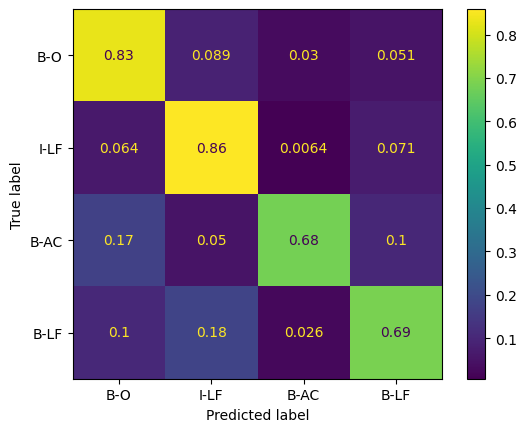

In [25]:
#Uncomment the below lines only when loading a saved model. Change the name as needed.

#model_path = '/content/drive/MyDrive/NLP/Models/adam-10.pth'
#model.load_state_dict(torch.load(model_path, map_location=DEVICE))
#model.to(DEVICE)
model.eval()  # Set the model to evaluation mode
true_labels = []
pred_labels = []

with torch.no_grad():
    for batch in val_iter:
        texts, text_lengths = batch.text[0], batch.text[1]
        labels = batch.labels

        # Transfer texts and labels to the device (GPU or CPU)
        texts = texts.to(DEVICE)
        labels = labels.to(DEVICE)

        # Ensure text_lengths is on the CPU (for compatability while using a GPU)
        text_lengths = text_lengths.cpu()  # Move text_lengths to CPU

        # Model inference
        outputs = model(texts, text_lengths)
        predictions = outputs.argmax(dim=2)

        # Collect predictions and labels for evaluation
        for i, length in enumerate(text_lengths):
            true_labels.extend(labels[i][:length].cpu().numpy())
            pred_labels.extend(predictions[i][:length].cpu().numpy())

# Calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

validation_accuracy = accuracy_score(true_labels, pred_labels)
validation_precision = precision_score(true_labels, pred_labels, average='macro')
validation_recall = recall_score(true_labels, pred_labels, average='macro')
validation_f1 = f1_score(true_labels, pred_labels, average='macro')

# Output F1 score for each class
label_names = ['B-O', 'I-LF', 'B-AC', 'B-LF']
f1_scores_per_class = f1_score(true_labels, pred_labels, labels=[2, 3, 4, 5], average=None)
for label, score in zip(label_names, f1_scores_per_class):
    print(f'F1 score for {label}: {score:.4f}')

print(f'Validation Accuracy: {validation_accuracy:.4f}')
print(f'Validation Precision: {validation_precision:.4f}')
print(f'Validation Recall: {validation_recall:.4f}')
print(f'Validation F1 Score: {validation_f1:.4f}')

# Display confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=[2, 3, 4, 5], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp_plot = disp.plot()

### Test Loop

In [26]:
def calculate_test_metrics(model, test_iter, device=DEVICE):
    #Uncomment the below lines only if you are loading a saved model.

    #model_path = '/content/drive/MyDrive/NLP/Models/adam-10.pth'
    #model.load_state_dict(torch.load(model_path, map_location=device))
    #model.to(device)
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    pred_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in test_iter:
            texts, text_lengths = batch.text[0], batch.text[1]
            labels = batch.labels

            # Transfer data to the appropriate device
            texts = texts.to(device)
            labels = labels.to(device)

            # Ensure text_lengths is on the CPU for compatibility with GPU for pack_padded_sequence
            text_lengths = text_lengths.cpu()

            # Get model predictions
            outputs = model(texts, text_lengths)
            predictions = outputs.argmax(dim=2)

            # Collect all predictions for evaluation
            for i in range(min(len(text_lengths), predictions.size(0))):
                length = text_lengths[i].item()
                all_predictions.extend(predictions[i][:length].cpu().numpy())

            # Flatten outputs and labels for metric calculation
            for i in range(len(text_lengths)):  # Use the actual number of items in the batch
                length = text_lengths[i].item()  # Ensure length is used as a Python int
                if i < labels.size(0):  # Additional check to prevent out-of-bounds error
                    batch_labels = labels[i][:length].cpu().numpy()
                    batch_predictions = predictions[i][:length].cpu().numpy()
                    true_labels.extend(batch_labels)
                    pred_labels.extend(batch_predictions)
                else:
                    break  # Avoid accessing out-of-bounds indices

    # Calculate metrics using sklearn
    test_accuracy = accuracy_score(true_labels, pred_labels)
    test_precision = precision_score(true_labels, pred_labels, average='macro', zero_division=0)
    test_recall = recall_score(true_labels, pred_labels, average='macro', zero_division=0)
    test_f1 = f1_score(true_labels, pred_labels, average='macro')

    # F1 score for each label
    label_names = ['B-O', 'I-LF', 'B-AC', 'B-LF']
    f1_scores_per_class = f1_score(true_labels, pred_labels, labels=[2, 3, 4, 5], average=None)
    for label, score in zip(label_names, f1_scores_per_class):
        print(f'F1 score for {label}: {score:.4f}')

    # Print metrics
    print(f'Test Accuracy: {test_accuracy:.4f}')
    print(f'Test Precision: {test_precision:.4f}')
    print(f'Test Recall: {test_recall:.4f}')
    print(f'Test F1 Score: {test_f1:.4f}')

    # Display confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=[2, 3, 4, 5], normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot()

    return all_predictions

F1 score for B-O: 0.8924
F1 score for I-LF: 0.5789
F1 score for B-AC: 0.6643
F1 score for B-LF: 0.4377
Test Accuracy: 0.8174
Test Precision: 0.6696
Test Recall: 0.8134
Test F1 Score: 0.7147


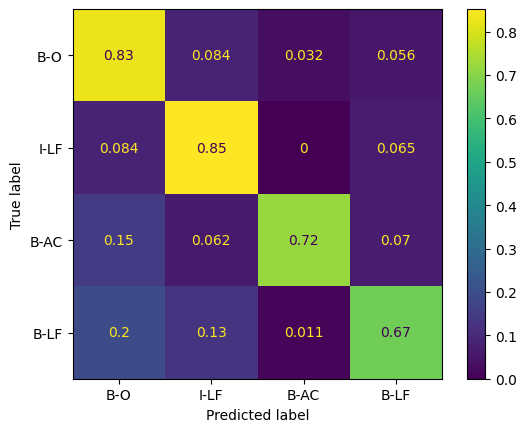

In [27]:
all_predictions = calculate_test_metrics(model, test_iter) #obtaining all_predictions to manually evaluate predicitons

### Obtaining predictions manually
Can include tokens from test dataset or random tokens.
Ensure the input is tokenised. For example: tokenized_words = ["protein", "D", "R", 'in']

In [28]:
def get_label_name(label_index):
    label_dict = {2: 'B-O', 3: 'I-LF', 4: 'B-AC', 5: 'B-LF'}
    return label_dict.get(label_index, "Unknown Label")

# Convert numeric predictions to actual label names
predicted_label_names = [get_label_name(label_idx) for label_idx in all_predictions]

# inspecting the `predicted_label_names` list.
print(predicted_label_names[:20])

['B-O', 'B-AC', 'B-LF', 'B-O', 'B-O', 'B-O', 'I-LF', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'I-LF', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'B-O']


In [29]:
#Function to obtain predictions on user input
def predict_labels(tokenized_sentence, model, text_field, label_field, device):
    model.eval()  # Ensure the model is in evaluation mode

    # Check if the input is a string; if so, split into tokens
    if isinstance(tokenized_sentence, str):
        tokenized_sentence = tokenized_sentence.split()

    # Numericalize the tokens using the vocabulary
    numericalized_tokens = [text_field.vocab.stoi[t] if t in text_field.vocab.stoi else text_field.vocab.stoi[text_field.unk_token] for t in tokenized_sentence]

    # Convert the list of indices into a tensor and add an extra dimension
    tensor = torch.LongTensor(numericalized_tokens).unsqueeze(1).to(device)

    # Length tensor is required for pack_padded_sequence
    lengths = torch.tensor([len(numericalized_tokens)]).to(device)

    # Get predictions from the model
    with torch.no_grad():
        predictions = model(tensor, lengths)
        predictions = predictions.view(-1, predictions.shape[-1])  # Reshape to 2d
        _, predicted_indices = torch.max(predictions, 1)

    # Convert numericalized indices to string labels
    predicted_labels = [label_field.vocab.itos[i] for i in predicted_indices.cpu().numpy()]

    return predicted_labels

# Obtaining the predictions:
tokenized_words = ["", "RNA", "Mass-Index"]
predicted_labels = predict_labels(tokenized_words, model, text_field, label_field, DEVICE)
print(predicted_labels)

['B-LF', 'B-LF', 'I-LF']
